In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
# import pylandau as pland
# import ROOT
import sys
import scipy.ndimage as ndimage
import numpy.ma as ma
from functions_MuonsNSAMP1 import *

def gaussian(x, a, mean, sigma, y_move):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) - y_move

# def gaussian(x, a, mean, sigma):
#     return a * np.exp(-((x - mean)**2 / (2 * sigma**2))) 

def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))
    
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4, letter
from reportlab.lib.utils import ImageReader

Welcome to JupyROOT 6.28/04


In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

ColorMap = 'jet'

In [3]:
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_13_KeV__NSAMP324.pkl'
# path = './Diccionarios_Espetro_Muones/dict_straight_muons_Extensions_1_to_4_Imgs_189_Elip_0.9_Sol_0.65_Skirts_0_NSIGMAS_20_KeV__NSAMP324.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1400_SIZE_250x539_KeV_n.pkl'

histogram = open(path, 'rb')
data_histogram = pkl.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked'])

Se detectaron  2833  muones (contando las 3 extensiones)


In [4]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)


list_phi_ext1 = data_histogram['extension_' + str(Ext)]['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    # data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()
#     

,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,
15,213.427559,0.78777,0.759985,35.411153,253.554069,220.235367,0.088955,2475.794922


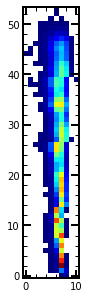

In [21]:
n_label = 15
display(DF_muons.iloc[[n_label]])

figure , axs = plt.subplots(1,1,figsize=[5,5])
axs.imshow(list_mask_rot[n_label],  cmap = ColorMap)  # 77, 1911, 2381, 2930 indices para path con elip 0.85, Sol 0.7
plt.show()


Numper of rows:  41
Long of line:  2


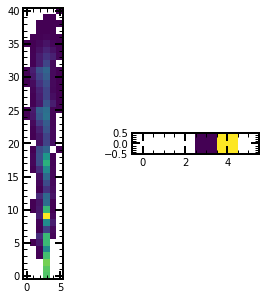

In [6]:
# label_verticalMuon, nlabels_verticalMuon = ndimage.label(list_mask_rot[105],structure=[[0,0,0],[1,1,1],[0,0,0]])

# label = 21
# ### Parte de abajo de la imagen ##
# line = label_verticalMuon == label
# # # print(Delta_inicial)
# loc = ndimage.find_objects(label_verticalMuon == label)[0]
# mask_35 = np.invert(label_verticalMuon == label)
# data_mask = ma.masked_array(list_mask_rot[0][loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

figure , axs = plt.subplots(1,2,figsize=[5,5])


label_muon = 105
label_line = 40
muon = list_mask_rot[label_muon]
print('Numper of rows: ', muon.shape[0])
line = list_mask_rot[label_muon][label_line - 1:label_line][0]

n_longline = 0
for pixel in line:
    if pixel != 0:
        # print(pixel)
        n_longline += 1

print('Long of line: ', n_longline)

axs[0].imshow(list_mask_rot[label_muon])
axs[1].imshow(list_mask_rot[label_muon][label_line - 1:label_line])
plt.show()

In [7]:
list_index_long_muons = []
extension = 1

for index in range(0, len(list_mask_rot)):
    size_x = list_mask_rot[index].shape[1]
    size_y = list_mask_rot[index].shape[0]
    if size_y > 50:
        # print(size_x, size_y)
        list_index_long_muons.append(index)

# print(list_index_long_muons)+
print('Muones largos detectados: ', len(list_index_long_muons))
print('Indices: ', list_index_long_muons)

Muones largos detectados:  52
Indices:  [1, 9, 10, 15, 16, 17, 22, 32, 38, 44, 49, 50, 54, 68, 73, 86, 87, 88, 95, 96, 104, 106, 107, 114, 117, 137, 144, 154, 155, 158, 159, 160, 169, 172, 180, 183, 186, 196, 197, 206, 207, 213, 214, 219, 221, 222, 228, 242, 243, 250, 252, 257]


## Perfil Energético

Number of rows:  38


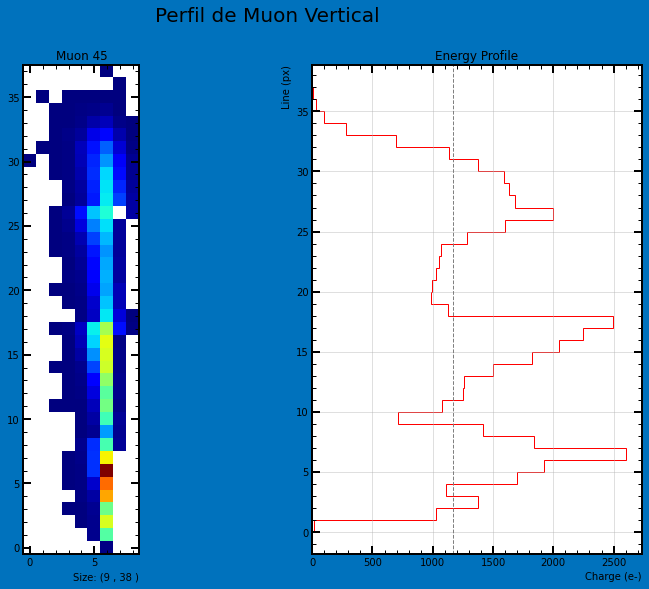

In [113]:
# list_muonlabels = [0, 10, 15, 16, 35, 36, 44, 47, 49, 55]
muon_label = 45  # Se coloca directamente el label del evento

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
event = list_mask_rot[muon_label]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())


### ==== Método con los labels de ndimage === ###
# label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

# charge_verticalMuon = []
# for lable_line in range(Delta_inicial, nlabels_verticalMuon - Delta_final):
    # line = label_verticalMuon == lable_line
    # loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    # mask_35 = np.invert(label_verticalMuon == lable_line)
    # data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    # # print(len(data_mask[0]))
    # charge = data_mask.sum()
    # print('Charge line ' + str(lable_line) + ': ', charge, ' , label_line: ', lable_line)
    # # print(charge)
    # mean_charge = data_mask.mean()

    # charge_verticalMuon.append(charge)
    # # print(charge)

### ========================================== ###



print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    charge = line.sum()/0.0036
    charge_verticalMuon.append(charge)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
# print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
axs[0].imshow(event, cmap = ColorMap)#, origin='upper')
axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2/0.0036, 0, size_y+2, linestyle='--', color='gray')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
# axs[1].set_xlabel('Charge (KeV)')
axs[1].set_xlabel('Charge (e-)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
# axs[1].legend()
axs[1].grid()
plt.show()

In [70]:
list_muonlabels = [0, 10, 15, 16, 35, 36, 44, 47, 49, 55]

for muon_label in list_muonlabels:
    event = list_mask_rot[muon_label]
    print('Muon: ', muon_label, ', Shape (X, Y): ', event.shape[1], event.shape[0])

Muon:  0 , Shape (X, Y):  8 43
Muon:  10 , Shape (X, Y):  12 82
Muon:  15 , Shape (X, Y):  11 54
Muon:  16 , Shape (X, Y):  5 52
Muon:  35 , Shape (X, Y):  10 47
Muon:  36 , Shape (X, Y):  10 40
Muon:  44 , Shape (X, Y):  8 59
Muon:  47 , Shape (X, Y):  9 35
Muon:  49 , Shape (X, Y):  11 75
Muon:  55 , Shape (X, Y):  9 40


Number of rows:  38


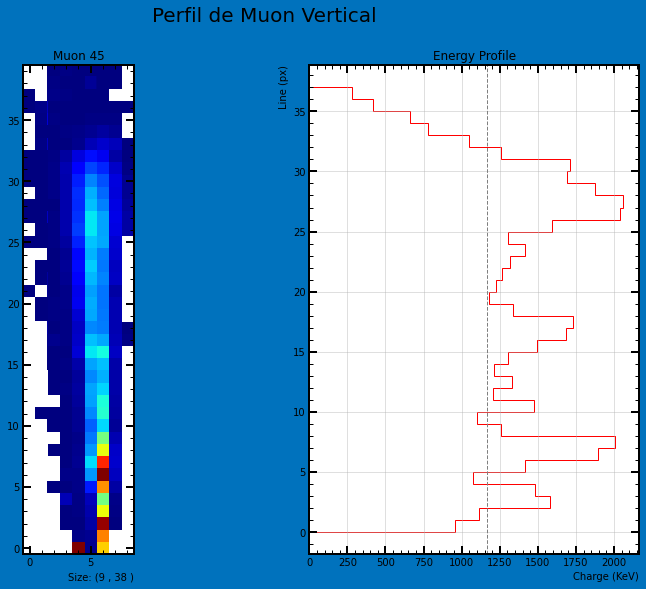

In [111]:
# list_muonlabels = [0, 10, 15, 16, 35, 36, 44, 47, 49, 55]
list_muonlabels = [0, 45,55,112]


muon_label = 45  # Se coloca directamente el label del evento
muon_label2 = 0
muon_label3 = 55
muon_label4 = 112

Delta_inicial = 0
Delta_final = 0
extension = 1

fig, axs = plt.subplots(ncols=2, nrows=1, figsize = [13,9], facecolor = [0, 0.4470, 0.7410])
fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

# for event in matrix_ext_4_vertical[num:num + 1]:

# event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)
event = list_mask_rot[muon_label]
event2 = list_mask_rot[muon_label2]
event3 = list_mask_rot[muon_label3]
event4 = list_mask_rot[muon_label4]
# plt.imshow(event)

size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y
# print(event.sum())


print('Number of rows: ', event.shape[0])
charge_verticalMuon = []
for index in range(1, size_y):
    line = event[index - 1:index][0]
    line2 = event2[index - 1:index][0]
    line3 = event3[index - 1:index][0]
    line4 = event4[index - 1:index][0]

    charge = line.sum()
    charge2 = line2.sum()
    charge3 = line3.sum()
    charge4 = line4.sum()

    mean_charge = (charge + charge2 + charge3 + charge4)/4

    charge_verticalMuon.append(mean_charge/0.0036)

## Linea inferior ##
# line_inf = [size_x]
# axs[0].imshow(data_mask)
# print(charge_verticalMuon[0], charge_verticalMuon[-1])
        
# cmap = 'plasma'
# axs[0].imshow(event[0:38, 0:8] + event2[:38, :8] + event3[:38, :8] + event4[:38, :8])#+ event3 + event4, cmap = ColorMap)#, origin='upper')

axs[0].imshow(event, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event2, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event3, cmap = ColorMap)#, origin='upper')
axs[0].imshow(event4, cmap = ColorMap)#, origin='upper')


axs[0].set_title('Muon ' + str(muon_label))
axs[0].set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs[1].stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#,  hatch = '////')
axs[1].axvline(4.2/0.0036, 0, size_y+2, linestyle='--', color='gray')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs[1].set_xlabel('Charge (KeV)')
axs[1].set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs[1].set_title('Energy Profile')
# axs[1].legend()
axs[1].grid()
plt.show()

# Modelo de Difusión

### Ajuste de gaussiana de una linea

/home/labdet/.local/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


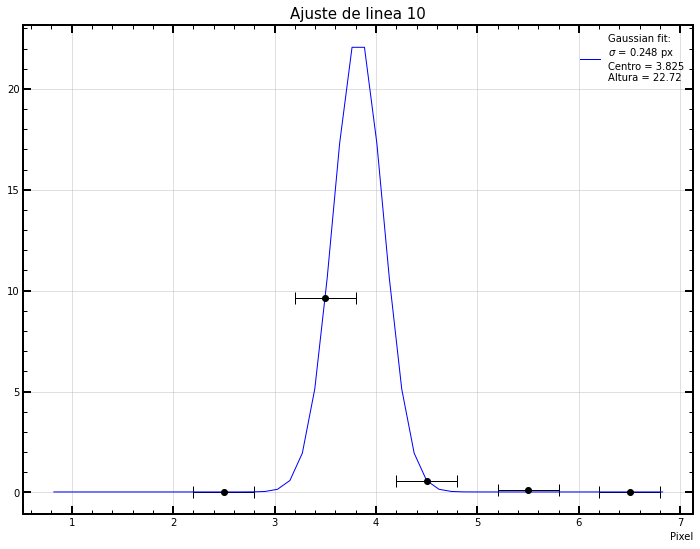

In [8]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px

extension = 1
label_muon = 1
label_sigma = label_muon

# img_sigma = matrix_ext_1_vertical_sigmas[label_sigma]
img_sigma = 0.0003 # KeV (se debe extraer la sima de cada imágen)
# print(img_sigma)

event = list_mask_rot[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]



lines = 0
Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


lable_line = 10

## Enmascara la linea en turno
line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)

 
# n_longline = 0
# for pixel in line:
#     if pixel != 0:
#         # print(pixel)
#         n_longline += 1
# Longitud_linea = n_longline
Longitud_linea = len(line)

Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

list_xlabel_long = np.linspace(-2, Longitud_linea+2, Longitud_linea)

popt, pcov = curve_fit(gaussian, list_xlabel, line, maxfev=100000, p0 = [8000, Mean_in, sigma_in, -2], method = 'lm')		# Fit histogram with gaussian


## Ajuste gaussiano con ROOT ##
# fgaus2 = TF1("fgauss","gaus",-4000,4000,3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
# h3=TH1F("histogram", "Distribution of OsCan",500, -4000,4000)

# for pixel_value in Overscan_plane.flatten():
#     # if not np.ma.is_masked(pixel_value):
#     h3.Fill(pixel_value)
#         #print(pixel_value)

# fgaus2.SetParameters(800,10,100) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
# h3.Fit(fgaus2)

## Se guardan lo parámetros del ajuste en un diccionario ##
dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2]), 'Pcov' : pcov}
Centroide = popt[1]
Sigma = abs(popt[2])
Altura = popt[0]

# print(Sigma)

# if Sigma > 6:
#     continue

# print(data_mask[0])

fig, axs_all = plt.subplots(figsize = [12,9])

# ## Se grafican los puntos experimentales ##
# axs_all.scatter(list_xlabel, data_mask[0], marker='.', color = 'k')  # 2D
# axs_all.scatter(list_xlabel_long, data_mask[0], lable_line, marker='.', color = 'k')  # 3D

for index_point in np.arange(0, len(list_xlabel)):
    try:
        axs_all.errorbar(x=list_xlabel[index_point], y=line[index_point], xerr= 3/10, yerr=img_sigma, marker='o', color = 'k', ecolor='k', linestyle = ' ', capsize=6)
    except:
        continue

# ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
list_xlabel_long = np.linspace( Centroide - 3 , Centroide + 3)

axs_all.plot(list_xlabel_long, gaussian(list_xlabel_long, *popt), 'b', label = 'Gaussian fit: \n' +'$\sigma$ = ' + str(np.around(Sigma, 3)) + ' px \nCentro = ' + str(np.around(Centroide, 3)) + '\nAltura = '
                                                                                                + str(np.around(Altura, 2)))	# 2D
# axs_all.plot(list_xlabel_long, gaussian(list_xlabel_long, *popt), lable_line, 'k', label = r'Gaussian fit: $\sigma$ = ' + str(Sigma))	#3D
# axs_all.legend()


# fig.suptitle('Ajuste de linea ' + str(lable_line))
axs_all.set_title('Ajuste de linea ' + str(lable_line),  size = 15)#, y=0.92)
axs_all.set_xlabel('Pixel')
axs_all.grid()
axs_all.legend()


plt.show()

Lonitud de la linea:  9
Sigma fit:  0.30156153669764396



Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).


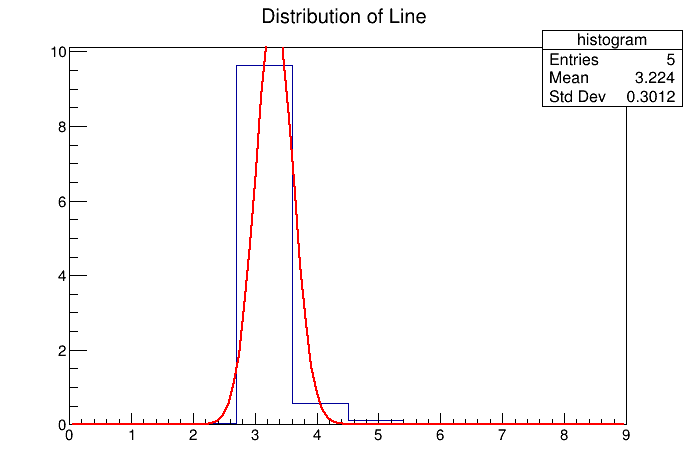

In [10]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
lable_line = 10
img_sigma = 0.0003  # KeV 
# print(img_sigma)

## Se checa si el muon tiene la orientación correcta
event = list_mask_rot[label_muon]
size_x = event.shape[1]
size_y = event.shape[0]

# lines = 0
Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)


line = event[lable_line - 1:lable_line][0]
Carga_renglon = line.sum()
Mean_carga = np.mean(line)


Mean_in  = 0
var = 0
carga_cuadrada = 0

### Se calcula el X promedio ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = (pixel * line[pixel]) / Carga_renglon
        Mean_in = Mean_in + element_pixel
    else:
        element_pixel = 0
    
    Mean_in = Mean_in + element_pixel

## Calcula la suma de las cargas al cuadrado ##
for pixel in np.arange(0, Longitud_linea, 1):
    if line[pixel]:
        element_pixel = line[pixel]**2
    else:
        element_pixel = 0

    carga_cuadrada = carga_cuadrada + element_pixel 

Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

### Se calcula la varianza ##
for pixel in np.arange(0, Longitud_linea, 1):
    element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
    var = var + element_pixel  ### COreggir la varianza con otro estimados

### Se corrige la varianza con la carga ###
var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

### Se calcula la sigma ###
sigma_in = np.sqrt(var)
# sigma_in = np.sqrt(var_true)


##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
list_xlabel = np.arange(0.5, len(line), 1)

# list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

# popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

print('Lonitud de la linea: ', len(line.flatten()))

## Ajuste gaussiano con ROOT ##
fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

for index in range(0, len(line)):
    if line[index] != 0:
        # print(index, line[index])
        h3.SetBinContent( index + 1, line[index])
        # h3.SetBinError(index + 1, 0.001)
        #print(pixel_value)

fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
h3.Fit(fgaus2, "RQN")

fit_const = fgaus2.GetParameters()[0]
fit_mean = fgaus2.GetParameters()[1]
fit_sigma = fgaus2.GetParameters()[2]
print('Sigma fit: ', fit_sigma, end='\n\n')

c3=TCanvas()

h3.Draw()
c3.Draw()
fgaus2.Draw("same")
# gStyle.SetOptFit(1100)
# gStyle.SetPadGridX (True)



# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


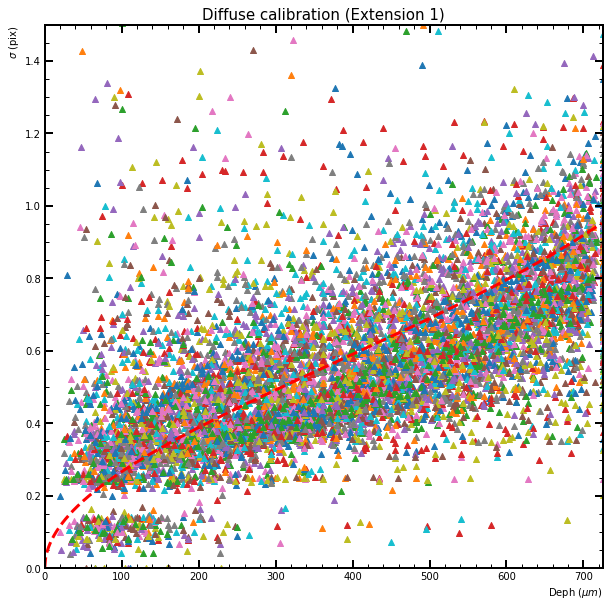

In [118]:
CCD_depth = 725 # micras
Delta_inicial = 3    # px
Delta_final = 6     # px
Bins = 50

extension = 1
label_muon = 1
img_sigma = 0.0003  # KeV 
# print(img_sigma)
fig, axs_all = plt.subplots(figsize = [10,10])

list_muonlabels = []
for index in range(0, len(list_mask_rot)):
    list_muonlabels.append(index)

# list_muonlabels = [0, 10, 15, 16, 22, 27, 32, 39, 44, 45, 50, 55, 61, 74, 105, 112, 117, 144, 159, 167, 185, 196, 203, 243, 252, ]

# list_muonlabels = [0, 16, 22, 27, 32,44, 45, 50, 55, 105, 144, 159, 167, 185, 203, 243, 252]
# 
# list_muonlabels = [10, 15, 39, 61, 74, 112, 117, 196 ]

# list_muonlabels = [10, 15, 74, 112, 117, 196 ]
# list_muonlabels = [0, 10, 15, 16, 32, 35, 36, 44, 47, 49, 55]
# list_muonlabels = [0, 45,55,112]



for label_muon in list_muonlabels: 
    event = list_mask_rot[label_muon]
    size_x = event.shape[1]
    size_y = event.shape[0]

    # lines = 0
    Longitud_XY = size_y 
    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)
    # print('Muon: ', label_muon, ', Shape (X, Y): ', event.shape[1], event.shape[0])

    list_fitsigmas = []
    for lable_line in range(Delta_inicial, size_y - Delta_final):
        line = event[lable_line - 1:lable_line][0]
        Carga_renglon = line.sum()
        Mean_carga = np.mean(line)
        Longitud_linea = len(line)


        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in range(0, Longitud_linea):
            if line[pixel]:
                element_pixel = (pixel * line[pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel = line[pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if line[pixel]:
                element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2 * line[pixel]
                var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        # var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))
        var_true = var / Carga_renglon

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # print(sigma_in)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(line), 1)

        # list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

        # popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [8000, Mean_in, sigma_in])		# Fit histogram with gaussian

        # print('Lonitud de la linea: ', len(line.flatten()))

        ## Ajuste gaussiano con ROOT ##
        fgaus2 = TF1("fgauss","gaus",  0,  len(line.flatten()), 3) # TF1("nombre", "funcion escrita como en root", min, max, #parametros)
        h3=TH1F("histogram", "Distribution of Line", len(line.flatten()) + 1, 0,  len(line.flatten()) )

        for index in range(0, len(line)):
            if line[index] != 0:
                # print(index, line[index])
                h3.SetBinContent( index + 1, line[index])
                # h3.SetBinError(index + 1, 0.001)
                #print(pixel_value)

        fgaus2.SetParameters(np.max(line),Mean_in,sigma_in) # Establecer parametros iniciales del fit, de manera visual es posible determinarlos como una primera aproximacion
        h3.Fit(fgaus2, "RQN")

        fit_const = fgaus2.GetParameters()[0]
        fit_mean = fgaus2.GetParameters()[1]
        fit_sigma = fgaus2.GetParameters()[2]


        # fit_sigma = sigma_in
        # print('Sigma fit: ', fit_sigma)
        list_fitsigmas.append(fit_sigma)


        # c3=TCanvas()

        # h3.Draw()
        # c3.Draw()
        # fgaus2.Draw("same")
        del h3
    # gStyle.SetOptFit(1100)
    # gStyle.SetPadGridX (True)

    list_deep = []
    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_fitsigmas))
    for deep in list_xlabel_sigmas:
        list_deep.append(deep)

    axs_all.scatter(list_deep, list_fitsigmas, marker='^')#, label = 'Muon: ' + str(label_muon))


def diffution_curve(z, alpha, beta):
    return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

fit_range = np.arange(0, 725)

axs_all.plot(fit_range, diffution_curve(fit_range, alpha=-0.646, beta=0.001042), '--r', linewidth = 3)

axs_all.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_ylim(0, 1.5)
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

/tmp/ipykernel_6737/4027048475.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs_all.legend()


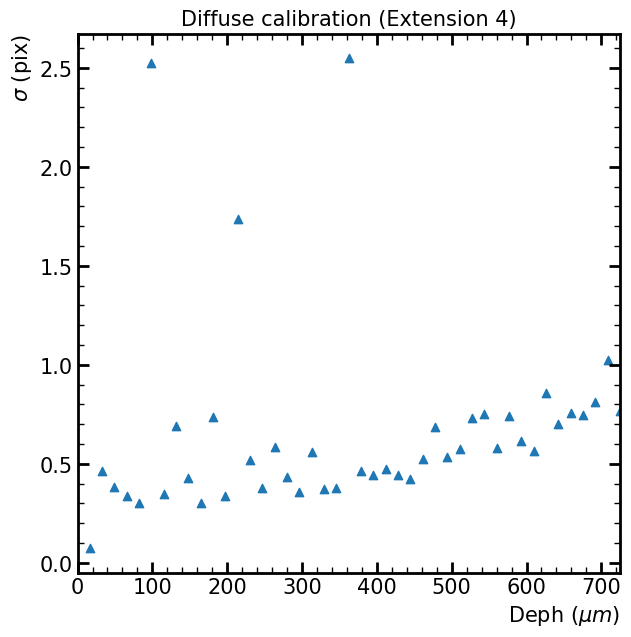

In [101]:
fig, axs_all = plt.subplots(figsize = [7,7])

axs_all.scatter(list_deep, list_fitsigmas, marker='^')

axs_all.set_title('Diffuse calibration (Extension 4)', size = 15)#, y=0.92)}
axs_all.set_ylabel(r'$\sigma$ (pix)')
axs_all.set_xlabel(r'Deph ($\mu m$)')
axs_all.set_xlim(0, 725)
axs_all.legend()
axs_all.grid
plt.show()

### Ajuste de difusión de algunos muones

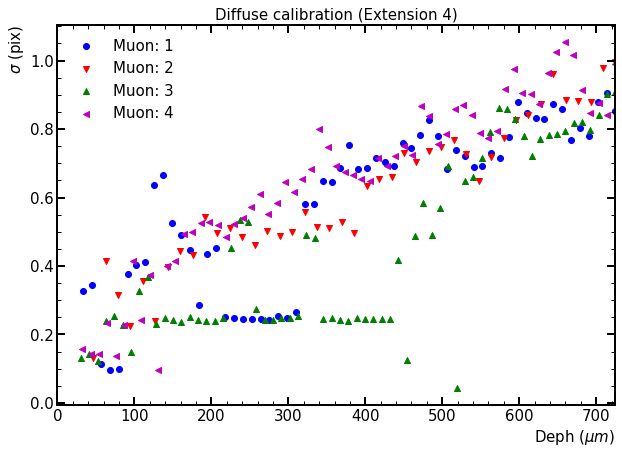

In [10]:
fig_2, axs_all_2 = plt.subplots(figsize = [10, 7])

Extension = 1

## Muons Extention 1
# muons_vertical_labels_1 = [[0], [1], [2], [4], [7]]
muons_vertical_labels_1 = [[37], [2], [3], [4]]#, [5]],  [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 21, 30, 32, 35, 36, 37]

#0, 2, 11, 13, 34
#1, 2, 7, 12, 13, 14, 18, 21, 30, 32, 36


## Muons Extention 2
# muons_vertical_labels_1 = [[2], [5], [6], [16]]#, [31]] 
# muons_vertical_labels_1 = [[14]]#, 1, 3, 8, 10, 12, 14]  [0, 1, 3, 8, 10, 12, 14]

# 1, 8, 12, 14

## Muons Extention 4
# muons_vertical_labels_1 = [[73], [3], [6], [14], [27]] #, 23,  27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4
# muons_vertical_labels_1 = [[9]] #, 1, 4, 7, 9, 11] # [0, 1, 4, 5, 7, 9]
# 7, 9
# 1, 7, 

list_all_sigmas_1, list_all_deeps_1 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[0], Delta_in=3, Delta_fin=8, extension= Extension)
list_all_sigmas_2, list_all_deeps_2 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[1], Delta_in=3, Delta_fin=5, extension= Extension)
list_all_sigmas_3, list_all_deeps_3 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[2], Delta_in=3, Delta_fin=5, extension= Extension)
list_all_sigmas_4, list_all_deeps_4 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[3], Delta_in=3, Delta_fin=5, extension= Extension)
# list_all_sigmas_5, list_all_deeps_5 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[4], Delta_in=5, Delta_fin=5, extension=1)


# axs_all_2.plot(list_all_deeps, list_all_sigmas, marker='o', color='k')#, label = 'Muon: ' + str(n_muon))
axs_all_2.scatter(list_all_deeps_1, list_all_sigmas_1, marker='o', color='b', label = 'Muon: 1')
axs_all_2.scatter(list_all_deeps_2, list_all_sigmas_2, marker='v', color='r', label = 'Muon: 2')
axs_all_2.scatter(list_all_deeps_3, list_all_sigmas_3, marker='^', color='g', label = 'Muon: 3')
axs_all_2.scatter(list_all_deeps_4, list_all_sigmas_4, marker='<', color='m', label = 'Muon: 4')
# axs_all_2.scatter(list_all_deeps_5, list_all_sigmas_5, marker='>', color='orange', label = 'Muon: 5')


# axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
# axs_all_2.set_title('Diffuse calibration (Extension 2)', size = 15)#, y=0.92)}
axs_all_2.set_title('Diffuse calibration (Extension 4)', size = 15)#, y=0.92)}
axs_all_2.set_ylabel(r'$\sigma$ (pix)')
axs_all_2.set_xlabel(r'Deph ($\mu m$)')
axs_all_2.set_xlim(0, 725)
axs_all_2.legend()
axs_all_2.grid

plt.show()



#### Con ROOT

Turn flag:  False


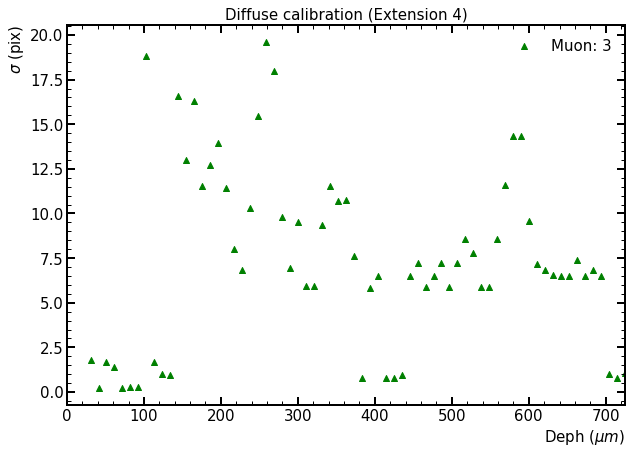

 FCN=6.56125e-11 FROM HESSE     STATUS=NOT POSDEF     16 CALLS          71 TOTAL
                     EDM=1.30964e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.48447e+00   1.82027e+01   1.40126e-04   5.79468e-06
   2  Mean         1.05410e+00   1.03474e+01   1.08046e-04  -1.24894e-05
   3  Sigma        1.81296e+00   1.43774e+01   3.49430e-06  -8.26781e-06
 FCN=1.72166e-07 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=3.4437e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.56595e+00   7.42102e+01   8.57141e-04  -4.57238e-04
   2  Mean         1.88534e-02   1.10602e+01   1.22906e-04   3.68519e-03
   3  Sigma        2.24888

Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: histogram (Potential memory leak).
Warning in <TROOT::Append>: Replacing exist

In [17]:
fig_2, axs_all_2 = plt.subplots(figsize = [10, 7])

Extension = 1

## Muons Extention 1
# muons_vertical_labels_1 = [[0], [1], [2], [4], [7]]
muons_vertical_labels_1 = [[37], [2], [3], [4]]#, [5]],  [1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 17, 18, 19, 21, 30, 32, 35, 36, 37]

#0, 2, 11, 13, 34
#1, 2, 7, 12, 13, 14, 18, 21, 30, 32, 36


## Muons Extention 2
# muons_vertical_labels_1 = [[2], [5], [6], [16]]#, [31]] 
# muons_vertical_labels_1 = [[14]]#, 1, 3, 8, 10, 12, 14]  [0, 1, 3, 8, 10, 12, 14]

# 1, 8, 12, 14

## Muons Extention 4
# muons_vertical_labels_1 = [[73], [3], [6], [14], [27]] #, 23,  27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4
# muons_vertical_labels_1 = [[9]] #, 1, 4, 7, 9, 11] # [0, 1, 4, 5, 7, 9]
# 7, 9
# 1, 7, 

# list_all_sigmas_1, list_all_deeps_1 = diffution_vertical_muon_ROOT(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[0], Delta_in=3, Delta_fin=5, extension= Extension)
# list_all_sigmas_2, list_all_deeps_2 = diffution_vertical_muon_ROOT(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[1], Delta_in=3, Delta_fin=5, extension= Extension)
list_all_sigmas_3, list_all_deeps_3 = diffution_vertical_muon_ROOT(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[2], Delta_in=3, Delta_fin=5, extension= Extension)
# list_all_sigmas_4, list_all_deeps_4 = diffution_vertical_muon_ROOT(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[3], Delta_in=3, Delta_fin=5, extension= Extension)
# list_all_sigmas_5, list_all_deeps_5 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1[4], Delta_in=5, Delta_fin=5, extension=1)


# axs_all_2.plot(list_all_deeps, list_all_sigmas, marker='o', color='k')#, label = 'Muon: ' + str(n_muon))
# axs_all_2.scatter(list_all_deeps_1, list_all_sigmas_1, marker='o', color='b', label = 'Muon: 1')
# axs_all_2.scatter(list_all_deeps_2, list_all_sigmas_2, marker='v', color='r', label = 'Muon: 2')
axs_all_2.scatter(list_all_deeps_3, list_all_sigmas_3, marker='^', color='g', label = 'Muon: 3')
# axs_all_2.scatter(list_all_deeps_4, list_all_sigmas_4, marker='<', color='m', label = 'Muon: 4')
# axs_all_2.scatter(list_all_deeps_5, list_all_sigmas_5, marker='>', color='orange', label = 'Muon: 5')


# axs_all_2.set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
# axs_all_2.set_title('Diffuse calibration (Extension 2)', size = 15)#, y=0.92)}
axs_all_2.set_title('Diffuse calibration (Extension 4)', size = 15)#, y=0.92)}
axs_all_2.set_ylabel(r'$\sigma$ (pix)')
axs_all_2.set_xlabel(r'Deph ($\mu m$)')
axs_all_2.set_xlim(0, 725)
axs_all_2.legend()
axs_all_2.grid

plt.show()



### Ajuste de la curva de difusión (por extensión)

Alpha:  0.6599168319213301  Beta:  0.001042306366943606
Alpha:  0.7575528553324898  Beta:  0.0010104840893904157
Alpha:  1.670334719793734  Beta:  0.0008197900208870759


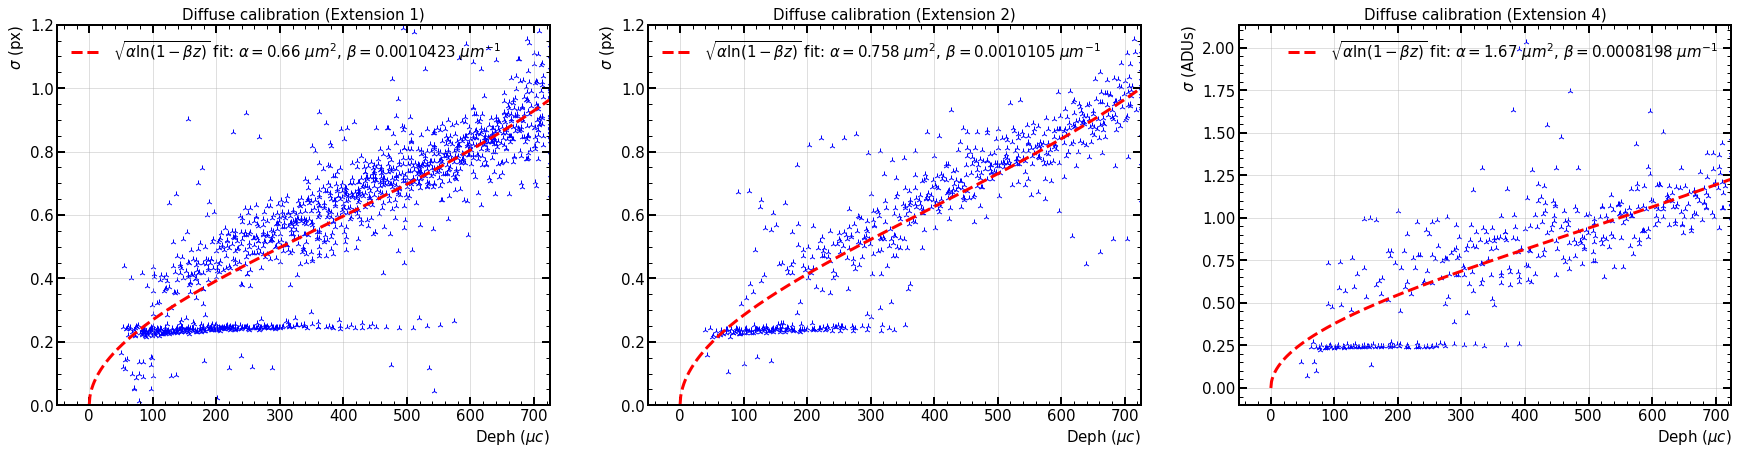

In [25]:
# fig_all, axs_all = plt.subplots(1, 2, figsize=(12, 6))
# fig, axs_all = plt.subplots( subplot_kw={"projection": "3d"}, figsize = [10,10])
fig_2, axs_all_2 = plt.subplots(1,3, figsize = [30, 7])

# Extension = 1
# muons_labels = [1,2, 3, 5, 8, 9, 15, 18, 33, 40]
# muons_labels = [1,2, 3, 5, 8, 9, 15, 18, 33, 51, 54, 63, 64] # Extensión 1


# muons_vertical_labels_1 = [0, 1, 2, 4, 7, 8, 14, 17, 32, 50, 53, 62, 63] # Extensión 1
# muons_vertical_labels_2 = [2, 5, 6, 16, 31, 32, 41, 44, 60, 72] # Extensión 2
# muons_vertical_labels_4 = [2, 3, 6, 14, 16, 23, 27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4


### NSAMP 324 ###

muons_vertical_labels_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37] # Extensión 1
muons_vertical_labels_2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # Extensión 2
muons_vertical_labels_4 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]# Extensión 4


list_all_sigmas_1, list_all_deeps_1 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_1, Delta_in=5, Delta_fin=8, extension=1)
list_all_sigmas_2, list_all_deeps_2 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_2, Delta_in=5, Delta_fin=8, extension=2)
list_all_sigmas_4, list_all_deeps_4 = diffution_vertical_muon(dict = data_histogram, list_vertical_labels=muons_vertical_labels_4, Delta_in=5, Delta_fin=8, extension=4)

# list_all_sigmas = list_all_sigmas_1 + list_all_sigmas_2 + list_all_sigmas_4
# list_all_deeps = list_all_deeps_1 + list_all_deeps_2 + list_all_deeps_4

# axs_all_2.plot(list_all_deeps, list_all_sigmas, marker='o', color='k')#, label = 'Muon: ' + str(n_muon))
axs_all_2[0].scatter(list_all_deeps_1, list_all_sigmas_1, marker='2', color='b')#, label = 'Muon: ' + str(n_muon))
axs_all_2[1].scatter(list_all_deeps_2, list_all_sigmas_2, marker='2', color='b')#, label = 'Muon: ' + str(n_muon))
axs_all_2[2].scatter(list_all_deeps_4, list_all_sigmas_4, marker='2', color='b')#, label = 'Muon: ' + str(n_muon))


popt_DM_1, _ = curve_fit(diffution_curve, list_all_deeps_1, list_all_sigmas_1, maxfev=100000, p0= [100, 0.0001])
popt_DM_2, _ = curve_fit(diffution_curve, list_all_deeps_2, list_all_sigmas_2, maxfev=100000, p0= [100, 0.0001])
popt_DM_4, _ = curve_fit(diffution_curve, list_all_deeps_4, list_all_sigmas_4, maxfev=100000, p0= [100, 0.0001])


dict_diffution_model_1 = {'Alpha' : popt_DM_1[0], 'Beta' : popt_DM_1[1]}
dict_diffution_model_2 = {'Alpha' : popt_DM_2[0], 'Beta' : popt_DM_2[1]}
dict_diffution_model_4 = {'Alpha' : popt_DM_4[0], 'Beta' : popt_DM_4[1]}


print('Alpha: ', dict_diffution_model_1['Alpha'], ' Beta: ', dict_diffution_model_1['Beta'])
print('Alpha: ', dict_diffution_model_2['Alpha'], ' Beta: ', dict_diffution_model_2['Beta'])
print('Alpha: ', dict_diffution_model_4['Alpha'], ' Beta: ', dict_diffution_model_4['Beta'])

fit_range = np.arange(0, 725)
axs_all_2[0].plot(fit_range, diffution_curve(fit_range, *popt_DM_1), '--r', linewidth = 3, label = r'$\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model_1['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model_1['Beta'], 7)) + r' $ \mu m ^{-1}$')
axs_all_2[1].plot(fit_range, diffution_curve(fit_range, *popt_DM_2), '--r', linewidth = 3, label = r'$\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model_2['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model_2['Beta'], 7)) + r' $ \mu m ^{-1}$')
axs_all_2[2].plot(fit_range, diffution_curve(fit_range, *popt_DM_4), '--r', linewidth = 3, label = r'$\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model_4['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model_4['Beta'], 7)) + r' $ \mu m ^{-1}$')



axs_all_2[0].set_title('Diffuse calibration (Extension 1)', size = 15)#, y=0.92)}
axs_all_2[0].set_ylabel(r'$\sigma$ (px)')
axs_all_2[0].set_xlabel(r'Deph ($\mu c$)')
axs_all_2[0].set_xlim(-50, 725)
axs_all_2[0].set_ylim(0, 1.2)
axs_all_2[0].legend()
axs_all_2[0].grid()

axs_all_2[1].set_title('Diffuse calibration (Extension 2)', size = 15)#, y=0.92)}
axs_all_2[1].set_ylabel(r'$\sigma$ (px)')
axs_all_2[1].set_xlabel(r'Deph ($\mu c$)')
axs_all_2[1].set_xlim(-50, 725)
axs_all_2[1].set_ylim(0, 1.2)
axs_all_2[1].legend()
axs_all_2[1].grid()

axs_all_2[2].set_title('Diffuse calibration (Extension 4)', size = 15)#, y=0.92)}
axs_all_2[2].set_ylabel(r'$\sigma$ (ADUs)')
axs_all_2[2].set_xlabel(r'Deph ($\mu c$)')
axs_all_2[2].set_xlim(-50, 725)
axs_all_2[2].legend()
axs_all_2[2].grid()

plt.show()



### Ajuste de la extensión 1 y 4 

Alpha:  -0.672529579645043  Beta:  0.0010790390148876126


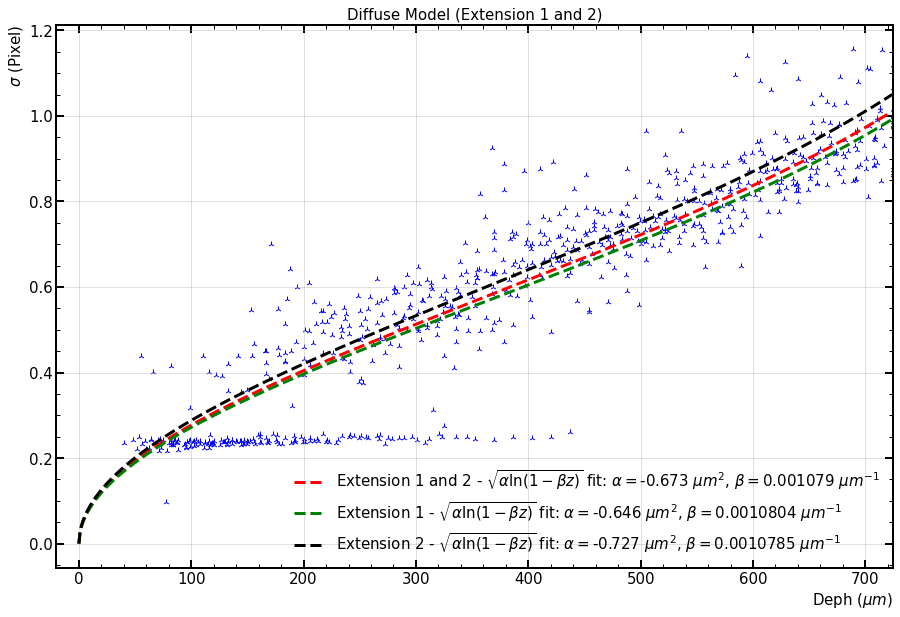

In [94]:
# all_sigmas_ext_1_4 = list_all_sigmas_1 + list_all_sigmas_4
# all_deeps_ext_1_4 = list_all_deeps_1 + list_all_deeps_4

all_sigmas_ext_1_4 = list_all_sigmas_1 + list_all_sigmas_2
all_deeps_ext_1_4 = list_all_deeps_1 + list_all_deeps_2

popt_DM, _ = curve_fit(diffution_curve, all_deeps_ext_1_4, all_sigmas_ext_1_4, maxfev=100000, p0= [100, 0.0001])
dict_diffution_model = {'Alpha' : popt_DM[0], 'Beta' : popt_DM[1]}
print('Alpha: ', dict_diffution_model['Alpha'], ' Beta: ', dict_diffution_model['Beta'])

fig_2, axs_all_2 = plt.subplots(figsize = [15, 10])

axs_all_2.scatter(all_deeps_ext_1_4, all_sigmas_ext_1_4, marker='2', color='b')#, label = 'Muon: ' + str(n_muon))

fit_range = np.arange(0, 725)
axs_all_2.plot(fit_range, diffution_curve(fit_range, *popt_DM), '--r', linewidth = 3, label = r'Extension 1 and 2 - $\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model['Beta'], 7)) + r' $ \mu m ^{-1}$')

axs_all_2.plot(fit_range, diffution_curve(fit_range, *popt_DM_1), '--g', linewidth = 3, label = r'Extension 1 - $\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model_1['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model_1['Beta'], 7)) + r' $ \mu m ^{-1}$')
axs_all_2.plot(fit_range, diffution_curve(fit_range, *popt_DM_2), '--k', linewidth = 3, label = r'Extension 2 - $\sqrt{\alpha \ln (1 - \beta z)}$ fit: $\alpha = $'  + str( np.round(dict_diffution_model_2['Alpha'], 3)) + 
                                                                                                    r' $\mu m^2$, $\beta = $' + str( np.round(dict_diffution_model_2['Beta'], 7)) + r' $ \mu m ^{-1}$')


axs_all_2.set_title('Diffuse Model (Extension 1 and 2)', size = 15)#, y=0.92)}
axs_all_2.set_ylabel(r'$\sigma$ (Pixel)')
axs_all_2.set_xlabel(r'Deph ($\mu m$)')
axs_all_2.set_xlim(-20, 725)
axs_all_2.legend()
axs_all_2.grid()

plt.show()

### PDF de perfil energético para todos los muones (verticales)

In [54]:
# muon_label = 40  # Se coloca directamente el label del evento
# list_lebel_muon = [0, 1, 2, 4, 7, 8, 14, 17, 32, 50, 53, 62, 63] # Extensión 1
# list_lebel_muon = [2, 5, 6, 16, 31, 32, 41, 44, 60, 72] # Extensión 2
# list_lebel_muon = [2, 3, 6, 14, 16, 23, 27, 40, 43, 46, 49, 59, 85, 92, 94, 98] # Extensión 4
 
# alpha: -205., 1.032 * 10 **(-3)

### Imágenes NSAMP324 
# list_lebel_muon = [1,2, 12, 13, 14, 18, 21, 30, 32]# Extensión 1 , 14, 18, 21, 30, 32, 36
# list_lebel_muon = [1, 8, 12, 14] # Extension 2
list_lebel_muon = [4, 7, 9] # Extension 4 [0, 1, 4, 5, 7, 9]

CCD_depth = 725 # micras
Delta_inicial = 5
Delta_final = 8
extension = 4

ylim_max = 1.4

Sigmas_ADUs = data_histogram['extension_' + str(extension)]['vertical_sigmas']


# PDF_images_name = "Energy_per_slice_&_defuse_Vertical_Muons_model_Extension_" + str(extension) + ".pdf"
PDF_images_name = "Energy_per_slice_&_defuse_Vertical_Muons_model_Extension_" + str(extension) + "_NSAMP324.pdf"

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)
w, h = A4 ## dimensiones del formato
# c.showPage()

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
num_pages = 1

color_matrix = [0.6, 0.4470, 0.2410] ## ALgo café
# color_matrix = [0, 0.4470, 0.7410]  ## Azul
# coord3x2 = [[0,0],[0,1], [1,0], [1,1], [2,0], [2,1]]
coord3x2 =  [[0,0],[0,1], [1,0], [1,1]]


# fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)

### Deffuse curve for 680 CCD ##
# def diffution_curve(z, alpha, beta):
#     return np.sqrt(np.abs(alpha * np.log(1 - (beta * z))))

### Curvas de Defusión ###
x_label_680_CCD = np.arange(0, 725, 0.1)

y_label_725_CCD_NSAMP324 = diffution_curve(x_label_680_CCD, -0.673, 0.001089 ) # Extension 1 and 2

y_label_725_CCD_NSAMP1 = diffution_curve(x_label_680_CCD, 7.964,0.0002379) # Extensions 1 and 4

y_label_680_CCD = diffution_curve(x_label_680_CCD, -205, 1.032 * 10 **(-3))/15

for label_muon in list_lebel_muon:
    event, flag_turn = check_flip_vertical_muon(dict= data_histogram, label_muon=label_muon, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)

    # for event in matrix_ext_4_vertical[num:num + 1]:
    # plt.imshow(event)
    size_x = event.shape[1] # tamaño en x
    size_y = event.shape[0] # tamaño en y

    label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

    charge_verticalMuon = []
    list_dicts_popt = []

    num_lines_true = range(Delta_inicial, nlabels_verticalMuon - Delta_final)
    # print('Num de lineas: ', len(num_lines_true))

    Longitud_XY = size_y 

    Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)

    for lable_line in range(Delta_inicial, nlabels_verticalMuon - Delta_final):
        line = label_verticalMuon == lable_line
        loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
        mask_35 = np.invert(label_verticalMuon == lable_line)
        data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
        
        
        charge = data_mask[0].sum()
        mean_charge = data_mask.mean()    

        charge_verticalMuon.append(charge)
        # print(charge)

        ### ------------------------------ PAra abajo es lo del as gaussianas y el modelo de difusión --------------------- ###
        Longitud_linea = len(data_mask[0])
        Carga_renglon = data_mask[0].sum()
        Mean_carga = np.mean(data_mask[0])

        Mean_in  = 0
        var = 0
        carga_cuadrada = 0

        ### Se calcula el X promedio ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if data_mask[0][pixel]:
                element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
                Mean_in = Mean_in + element_pixel
            else:
                element_pixel = 0
            
            Mean_in = Mean_in + element_pixel

        ## Calcula la suma de las cargas al cuadrado ##
        for pixel in np.arange(0, Longitud_linea, 1):
            if data_mask[0][pixel]:
                element_pixel = data_mask[0][pixel]**2
            else:
                element_pixel = 0

            carga_cuadrada = carga_cuadrada + element_pixel 

        Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

        ### Se calcula la varianza ##
        for pixel in np.arange(0, Longitud_linea, 1):
            element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
            var = var + element_pixel  ### COreggir la varianza con otro estimados

        ### Se corrige la varianza con la carga ###
        var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

        ### Se calcula la sigma ###
        sigma_in = np.sqrt(var)
        # sigma_in = np.sqrt(var_true)


        ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
        list_xlabel = np.arange(0.5, len(data_mask[0]), 1)

        list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

        popt, _= curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=1000000)#, p0 = [1000, Mean_in, sigma_in])		# Fit histogram with gaussian

        ## Se guardan lo parámetros del ajuste en un diccionario ##
        dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2]), 'Points' : data_mask[0], 'Xlabel' : list_xlabel}

        list_dicts_popt.append(dict_popt)

    list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_dicts_popt))



    list_all_sigmas = []
    for index in range(0, len(list_dicts_popt)):
        list_all_sigmas.append(list_dicts_popt[index]['sigma'])


    ### Figura del muon, perfil de energía y modelo de difusión 

    fig = plt.figure(figsize=[8,9])
    axs1 = plt.subplot(231)
    axs2 = plt.subplot(232)
    axs4 = plt.subplot(233)
    axs3 = plt.subplot(212)

    ### Image muon ###
    axs1.imshow(data_histogram['extension_' + str(extension)]['Vertical_Events'][label_muon], cmap= ColorMap)
    axs1.set_title('Muon ' + str(label_muon))
    axs1.set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
    # x0bar = fig.colorbar(x0, ax=axs[0])

    # reverse_list = charge_verticalMuon[::-1]
    # print(reverse_list)

    # print(charge_verticalMuon)

    if flag_turn:
        ### Energy profile ##
        axs2.stairs(charge_verticalMuon[::-1], np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#, hatch = '////')
        # axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
        axs2.set_xlabel('Charge (ADUs)')
        axs2.set_ylabel('Line (px)')
        # axs[1].set_ylim(0,len(event) - 1 )
        axs2.set_title('Energy per Slice')
        # axs[1].legend()
        axs2.grid()

        ## Sigma Profile ##
        axs4.stairs(list_all_sigmas[::-1], np.arange(0,len(charge_verticalMuon)+1), orientation = 'horizonral', color='r')
        axs4.set_xlabel(r'$\sigma$ (px)')
        axs4.set_ylabel('Line (px)')
        # axs[1].set_ylim(0,len(event) - 1 )
        axs4.set_title('Sigma per Slice')
        # axs[1].legend()
        axs4.grid()

        ## Deffuse Model ##
        axs3.scatter(list_xlabel_sigmas, list_all_sigmas, marker='^', color='g')#, label = 'Muon: ' + str(label_muon))
        axs3.plot(x_label_680_CCD, y_label_680_CCD, color='k', linestyle = '--', label = r'CCD 680 $\mu m$') #y_label_725_CCD_NSAMP1
        axs3.plot(x_label_680_CCD, y_label_725_CCD_NSAMP1, color='r', linestyle = '--', label = r'CCD 725 $\mu m$: NSAMP1 Extensions 1 & 4' ) #y_label_725_CCD_NSAMP324
        axs3.plot(x_label_680_CCD, y_label_725_CCD_NSAMP324, color='b', linestyle = '--', label = r'CCD 725 $\mu m$: NSAMP324 Extensions 1 & 2' )
        axs3.set_xlabel(r'Deep ($\mu m$)')
        axs3.set_ylabel(r'$\sigma$ (px)')
        axs3.set_xlim(-50, 750)
        axs3.set_ylim(0, ylim_max)
        axs3.set_title('Diffuse Data ')
        axs3.legend()
        axs3.grid()


        plt.tight_layout()
        fig.savefig(path_image)
        img = ImageReader(path_image)

        # Obtener el ancho y alto de la imagen.
        img_w, img_h = img.getSize()

        # h - img_h es el alto de la hoja menos el alto de la imagen.
        c.drawImage(img, w - img_w + 0, h - img_h - 60)
        c.drawString(w/2, 40, str(num_pages))
        c.showPage()
        # plt.imshow(event)
        # plt.show()
        plt.close()
        ! rm Perfil_Muon.jpg  ## Borra la imagen auxiliar

        num_pages = num_pages + 1

    else:
        ### Energy profile ##
        axs2.stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', color = 'r')#, hatch = '////')
        # axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
        axs2.set_xlabel('Charge (ADUs)')
        axs2.set_ylabel('Line (px)')
        # axs[1].set_ylim(0,len(event) - 1 )
        axs2.set_title('Energy per Slice')
        # axs[1].legend()
        axs2.grid()

        ## Sigma Profile ##
        axs4.stairs(list_all_sigmas, np.arange(0,len(charge_verticalMuon)+1), orientation = 'horizonral', color='r')
        axs4.set_xlabel(r'$\sigma$ (px)')
        axs4.set_ylabel('Line (px)')
        # axs[1].set_ylim(0,len(event) - 1 )
        axs4.set_title('Sigma per Slice')
        # axs[1].legend()
        axs4.grid()

        ## Deffuse Model ##
        axs3.scatter(list_xlabel_sigmas, list_all_sigmas, marker='^', color='g')#, label = 'Muon: ' + str(label_muon))
        axs3.plot(x_label_680_CCD, y_label_680_CCD, color='k', linestyle = '--', label = r'CCD 680 $\mu m$') #y_label_725_CCD_NSAMP1
        axs3.plot(x_label_680_CCD, y_label_725_CCD_NSAMP1, color='r', linestyle = '--', label = r'CCD 725 $\mu m$: NSAMP1 Extensions 1 & 4' )
        axs3.plot(x_label_680_CCD, y_label_725_CCD_NSAMP324, color='b', linestyle = '--', label = r'CCD 725 $\mu m$: NSAMP324 Extensions 1 & 2' )
        axs3.set_xlabel(r'Deep ($\mu m$)')
        axs3.set_ylabel(r'$\sigma$ (px)')
        axs3.set_title('Diffuse Data ')
        axs3.set_xlim(-50, 750)
        axs3.set_ylim(0, ylim_max )
        axs3.legend()
        axs3.grid()


        plt.tight_layout()
        fig.savefig(path_image)
        img = ImageReader(path_image)

        # Obtener el ancho y alto de la imagen.
        img_w, img_h = img.getSize()

        # h - img_h es el alto de la hoja menos el alto de la imagen.
        c.drawImage(img, w - img_w + 0, h - img_h - 60)
        c.drawString(w/2, 40, str(num_pages))
        c.showPage()
        # plt.imshow(event)
        # plt.show()
        plt.close()
        ! rm Perfil_Muon.jpg  ## Borra la imagen auxiliar

        num_pages = num_pages + 1
            
plt.close()
c.save()




OptimizeWarning: Covariance of the parameters could not be estimated

### PDF de perfil energético con ajustes gaussianos para un muon (vertical)

In [41]:
muon_label = 40  # Se coloca directamente el label del evento

CCD_depth = 725 # micras
Delta_inicial = 3
Delta_final = 6
extension = 4
Sigmas_ADUs = data_histogram['extension_' + str(extension)]['vertical_sigmas']


PDF_images_name = "Deffuse_model_for_one_muon.pdf"

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)
w, h = A4 ## dimensiones del formato
# c.showPage()

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
num_pages = 0

color_matrix = [0.6, 0.4470, 0.2410] ## ALgo café
# color_matrix = [0, 0.4470, 0.7410]  ## Azul
# coord3x2 = [[0,0],[0,1], [1,0], [1,1], [2,0], [2,1]]
coord3x2 =  [[0,0],[0,1], [1,0], [1,1]]


# fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)


event, _ = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)

# for event in matrix_ext_4_vertical[num:num + 1]:
size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

print(len(label_verticalMuon), nlabels_verticalMuon)
charge_verticalMuon = []
list_dicts_popt = []

num_lines_true = range(Delta_inicial, nlabels_verticalMuon - Delta_final)
print('Num de lineas: ', len(num_lines_true))

Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)

for lable_line in range(Delta_inicial, nlabels_verticalMuon - Delta_final):
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    
    
    charge = data_mask[0].sum()
    mean_charge = data_mask.mean()    

    charge_verticalMuon.append(charge)
    # print(charge)

    ### ------------------------------ PAra abajo es lo del as gaussianas y el modelo de difusión --------------------- ###
    Longitud_linea = len(data_mask[0])
    Carga_renglon = data_mask[0].sum()
    Mean_carga = np.mean(data_mask[0])

    Mean_in  = 0
    var = 0
    carga_cuadrada = 0

    ### Se calcula el X promedio ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
            Mean_in = Mean_in + element_pixel
        else:
            element_pixel = 0
        
        Mean_in = Mean_in + element_pixel

    ## Calcula la suma de las cargas al cuadrado ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = data_mask[0][pixel]**2
        else:
            element_pixel = 0

        carga_cuadrada = carga_cuadrada + element_pixel 

    Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

    ### Se calcula la varianza ##
    for pixel in np.arange(0, Longitud_linea, 1):
        element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
        var = var + element_pixel  ### COreggir la varianza con otro estimados

    ### Se corrige la varianza con la carga ###
    var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

    ### Se calcula la sigma ###
    sigma_in = np.sqrt(var)
    # sigma_in = np.sqrt(var_true)


    ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
    list_xlabel = np.arange(0.5, len(data_mask[0]), 1)

    list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

    popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [10000, Mean_in, sigma_in])		# Fit histogram with gaussian

    ## Se guardan lo parámetros del ajuste en un diccionario ##
    dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2]), 'Pcov' : pcov, 'Points' : data_mask[0], 'Xlabel' : list_xlabel}

    list_dicts_popt.append(dict_popt)

list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_dicts_popt))



list_all_sigmas = []
for index in range(0, len(list_dicts_popt)):
    list_all_sigmas.append(list_dicts_popt[index]['sigma'])


### Figura del muon, perfil de energía y modelo de difusión 

fig = plt.figure(figsize=[8,9])
axs1 = plt.subplot(221)
axs2 = plt.subplot(222)
axs3 = plt.subplot(212)


axs1.imshow(event)
axs1.set_title('Muon ' + str(muon_label))
axs1.set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs2.stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', hatch = '////', color = 'r')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs2.set_xlabel('Charge (ADUs)')
axs2.set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs2.set_title('Energy Profile')
# axs[1].legend()
axs2.grid()


axs3.scatter(list_xlabel_sigmas, list_all_sigmas, marker='^', color='g', label = 'Muon: ' + str(muon_label))
axs3.set_xlabel(r'Deep ($\mu m$)')
axs3.set_ylabel(r'$\sigma$ (px)')
axs3.set_title('Diffuse Data ')
axs3.grid()

plt.tight_layout()
fig.savefig(path_image)
img = ImageReader(path_image)

# Obtener el ancho y alto de la imagen.
img_w, img_h = img.getSize()

# h - img_h es el alto de la hoja menos el alto de la imagen.
c.drawImage(img, w - img_w + 0, h - img_h - 60)
c.drawString(w/2, 40, str(num_pages))
c.showPage()
# plt.imshow(event)
# plt.show()
plt.close()
! rm Perfil_Muon.jpg  ## Borra la imagen auxiliar

n_events = 0
n_lines = len(num_lines_true)

if (n_lines%6) == 0:
    # fig, axs_all = plt.subplots(3,2, figsize = [9,12], facecolor = color_matrix)
    fig, axs_all = plt.subplots(2,2, figsize = [9,12], facecolor = color_matrix)
    # fig = plt.figure(figsize=[8,9])
    # axs1 = plt.subplot(321)
    # axs2 = plt.subplot(322)
    # axs3 = plt.subplot(323)
    # axs3 = plt.subplot(323)

    for index in np.arange(0, len(list_dicts_popt)):

        if n_events < 5:
            Centroide = list_dicts_popt[index]['Mean']
            Altura = list_dicts_popt[index]['Hight']
            Sigma = list_dicts_popt[index]['sigma']
            Points = list_dicts_popt[index]['Points']
            list_xlabel = list_dicts_popt[index]['Xlabel']
            n_events = n_events + 1
            # print(Sigma)

            for index_point in np.arange(0, len(list_xlabel)):
                try:
                    axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].errorbar(x=list_xlabel[index_point], y=Points[index_point], xerr= 1/3, yerr= Sigmas_ADUs[muon_label], marker='o', color = 'k', ecolor='k', linestyle = ' ', capsize=6)
                except:
                    continue

            # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
            list_xlabel_long = np.linspace( Centroide - 3 , Centroide + 3) # gaussian(x, a, mean, sigma)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].plot(list_xlabel_long, gaussian(list_xlabel_long, a = Altura, mean= Centroide, sigma= Sigma), 
                                    'b', label = 'Gaussian fit: \n' +'$\sigma$ = ' + str(np.around(Sigma, 3)) + ' px \nCentro = ' + str(np.around(Centroide, 3)) + '\nAltura = ' + str(np.around(Altura, 2)))

            # axs_all.legend()

            # fig.suptitle('Ajuste de linea ' + str(lable_line))
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_title('Fit in line ' + str(index + 1),  size = 15)#, y=0.92)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_xlabel('Pixel')
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].grid()
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].legend()

            n_lines = n_lines - 1

            # plt.close()
            if n_events == 4:
                n_events = 5
        
        if n_events == 5:
            n_events = 0
            # num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 50, h - img_h - 60)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            # fig, axs_all = plt.subplots(3, 2, figsize = [9,12], facecolor = color_matrix)
            fig, axs_all = plt.subplots(2, 2, figsize = [9,12], facecolor = color_matrix)

        
if (n_lines%6) != 0:
    # fig, axs_all = plt.subplots(3,2, figsize = [9,12], facecolor = color_matrix)
    fig, axs_all = plt.subplots(2,2, figsize = [9,12], facecolor = color_matrix)
    # fig = plt.figure(figsize=[8,9])
    # axs1 = plt.subplot(321)
    # axs2 = plt.subplot(322)
    # axs3 = plt.subplot(323)
    # axs3 = plt.subplot(323)

    for index in np.arange(0, len(list_dicts_popt)):

        if n_events < 5:
            Centroide = list_dicts_popt[index]['Mean']
            Altura = list_dicts_popt[index]['Hight']
            Sigma = list_dicts_popt[index]['sigma']
            Points = list_dicts_popt[index]['Points']
            list_xlabel = list_dicts_popt[index]['Xlabel']

            n_events = n_events + 1
            # print(Sigma)
            
            for index_point in np.arange(0, len(list_xlabel)):
                try:
                    axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].errorbar(x=list_xlabel[index_point], y=Points[index_point], xerr= 1/3, yerr= Sigmas_ADUs[muon_label], marker='o', color = 'k', ecolor='k', linestyle = ' ', capsize=6)
                except:
                    continue

            # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
            list_xlabel_long = np.linspace( Centroide - 2 , Centroide + 2) # gaussian(x, a, mean, sigma)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].plot(list_xlabel_long, gaussian(list_xlabel_long, a = Altura, mean= Centroide, sigma= Sigma), 
                                    'b', label = 'Gaussian fit: \n' +'$\sigma$ = ' + str(np.around(Sigma, 3)) + ' px \nCentro = ' + str(np.around(Centroide, 3)) + '\nAltura = ' + str(np.around(Altura, 2)))

            # axs_all.legend()

            # fig.suptitle('Ajuste de linea ' + str(lable_line))
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_title('Fit in line ' + str(index + 1),  size = 15)#, y=0.92)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_xlabel('Pixel')
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].grid()
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].legend()

            n_lines = n_lines - 1

            # plt.close()
            if n_events == 4:
                n_events = 5
        
        if n_events == 5:
            n_events = 0
            # num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 50, h - img_h - 60)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            # fig, axs_all = plt.subplots(3, 2, figsize = [9,12], facecolor = color_matrix)
            fig, axs_all = plt.subplots(2, 2, figsize = [9,12], facecolor = color_matrix)

        
plt.close()
c.save()




52 52
Num de lineas:  43


# Visualizar Muones en PDF de una sola extensión y tipo

In [48]:
sample_horizontal = []
for index in (3, 31, 77, 617, 660, 792, 862, 1911, 2381, 2930):
    sample_horizontal.append(matrix_ext_4_vertical[index])

In [20]:
list_path = path.split('_')
print(list_path)
Elip_value = float(list_path[12])
Solidit_value = float(list_path[14])
Charge_units = list_path[15]

['/home/bruce/Documents/Programas/Catalogo', 'Eventos/dict', '', 'straight', 'muons', 'Extensions', '1', 'to', '4', 'Imgs', '2078', 'Elip', '0', 'Sol', '0.7', 'ADUs', '', '.pkl']


In [ ]:
### Nombre del PDF ###
extension = 1
list_path = path.split('_')
Elip_value = float(list_path[12])
Solidit_value = float(list_path[14])
Charge_units = list_path[15]

PDF_images_name = "Muones-Verticales_Ext_" + str(extension) + "_Elip_" + str(Elip_value) + "_Sol_" + str(Solidit_value) + '_Units_' + str(Charge_units) + '.pdf' 
# PDF_images_name = 
# PDF_images_name = "Muones-Horizontales_Ext_" + str(extension) + "_Elip_" + str(Elip_value) + "_Sol_" + str(Solidit_value) + '_Units_' + str(Charge_units) + '.pdf' 

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
color_matrix = [0.4, 0.4470, 0.2410]
# list_n_vertical = []
# list_n_events = []

n_events = 0
coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix) ## Las hojas tendrán 9 muones
w, h = A4 ## dimensiones del formato
num_pages = 0
c.showPage()
n_last_events = 0

# for extension in (1,2,4):
c.drawString(50, h - 50, 'Extensión ' + str(extension)) 
# n_vertical = len(dict_muons_true['extension_' +str(extension)]['Vertical_Events'])
n_vertical = len(sample_horizontal)
# n_vertical = len(data_histogram['extension_' + str(extension)]['Horizontal_Events']) + len(data_histogram['extension_' + str(extension)]['Vertical_Events'])
n_last_events = 0
n_events = 0
# print(n_vertical % 9 != 0)

if (n_vertical%9) == 0:
    # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
    for event in sample_horizontal:
        n_vertical = n_vertical - 1
        n_events = n_events + 1
        # list_n_vertical.append(n_vertical)
        # list_n_events.append(n_events)
        # print('n_events: ', n_events)
        # print('n_vertical: ', n_vertical)

        # print('n_vertical: ', n_vertical)
        if n_events < 10: 
            # print('n_events: ', n_events)
            charge = event.sum()
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Charge: ' + str(charge))

            if n_events == 9:
                n_events = 10

        if n_events == 10:
            n_events = 0
            num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 50, h - img_h - 60)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

if (n_vertical%9) != 0:
    Resto = n_vertical%9
    # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
    for event in sample_horizontal:
        n_vertical = n_vertical - 1
        n_events = n_events + 1
        # list_n_vertical.append(n_vertical)
        # list_n_events.append(n_events)
        # print('n_events: ', n_events)
        # print('n_vertical: ', n_vertical)

        if n_vertical >= Resto:
            # print('n_vertical: ', n_vertical)
            if n_events < 10: 
                # print('n_events: ', n_events)
                charge = event.sum()
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Charge: ' + str(charge))
                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages) + '.a')
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

        if  n_vertical < Resto:
            n_last_events = n_last_events + 1
            # fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = [0, 0.4470, 0.7410])
            # print('n_vertical: ', n_vertical)
            # print('n_last_events: ', n_last_events)
            charge = event.sum()
            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(event)
            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_xlabel('Charge: ' + str(charge))

            if n_vertical == 0:
                # plt.show()
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)




plt.close()
c.save()

## Visualizar en PDF TODOS los muones encontrados 

In [ ]:
list_path = path.split('_')
Elip_value = float(list_path[15])
Solidit_value = float(list_path[17])
# # Charge_units = list_path[17]
Charge_units = 'keV'


# print(list_path[16])num_pages = 0

In [29]:
print(list_path)

['./Diccionarios', 'Espetro', 'Muones/dict', '', 'straight', 'muons', 'Extensions', '1', 'to', '4', 'Imgs', '189', 'Elip', '0.9', 'Sol', '0.7', 'Skirts', '1', 'with', 'sigmas', 'ADUs', '', 'NSAMP324.pkl']


In [58]:
##### SOLO CORRER ESTA CELDA SI EL NÚMERO DE EVENTOS NO ES MUY GRANDE O EL PROCESO SERÁ DEMASIADO TARDADO #####

### Nombre del PDF ###
# extension = 1
list_path = path.split('_')
# Elip_value = float(list_path[14])
# Solidit_value = float(list_path[16])
# Charge_units = list_path[17]


color_matrix = [0.6, 0.4470, 0.2410] ## ALgo café

PDF_images_name = "Muones-Rectos_Elip_" + str(Elip_value) + "_Sol_" + str(Solidit_value) + '_Units_' + str(Charge_units) + '.pdf' 

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
num_pages = 0

# list_n_vertical = []
# list_n_events = []
for extension in (1,2,4):
    coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
    fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix) ## Las hojas tendrán 9 muones
    w, h = A4 ## dimensiones del formato
    c.showPage()

    # for extension in (1,2,4):
    c.drawString(50, h - 50, 'Extensión ' + str(extension)) 
    # n_vertical = len(dict_muons_true['extension_' +str(extension)]['Vertical_Events'])
    n_vertical = len(data_histogram['extension_' + str(extension)]['Vertical_Events'])
    n_horizontal = len(data_histogram['extension_' + str(extension)]['Horizontal_Events'])

    # n_vertical = len(data_histogram['extension_' + str(extension)]['Horizontal_Events']) + len(data_histogram['extension_' + str(extension)]['Vertical_Events'])
    n_last_events = 0
    n_events = 0
    # print(n_vertical % 9 != 0)
    n_label = 0
    
    if (n_vertical%9) == 0:
        # n_label = 1
        # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
        for event in data_histogram['extension_' + str(extension)]['Vertical_Events']:
            n_vertical = n_vertical - 1
            n_events = n_events + 1
            # list_n_vertical.append(n_vertical)
            # list_n_events.append(n_events)
            # print('n_events: ', n_events)
            # print('n_vertical: ', n_vertical)

            # print('n_vertical: ', n_vertical)
            if n_events < 10: 
                # print('n_events: ', n_events)
                charge = event.sum()
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event, cmap= ColorMap, norm = 'log')
                # axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Charge: ' + str(charge))
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Label: ' + str(n_label))

                n_label = n_label + 1

                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

    if (n_vertical%9) != 0:
        Resto = n_vertical%9
        # print(Resto)

        # n_label = 1
        
        # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
        for event in data_histogram['extension_' + str(extension)]['Vertical_Events']:
            n_vertical = n_vertical - 1
            n_events = n_events + 1
            # list_n_vertical.append(n_vertical)
            # list_n_events.append(n_events)
            # print('n_events: ', n_events)
            # print('n_vertical: ', n_vertical)

            if n_vertical >= Resto:
                # print('n_vertical: ', n_vertical)
                if n_events < 10: 
                    # print('n_events: ', n_events)
                    charge = event.sum()
                    axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event, cmap= ColorMap,  norm = 'log')
                    # axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Charge: ' + str(charge))
                    axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_ylabel('Label: ' + str(n_label))
                    n_label = n_label + 1
                    if n_events == 9:
                        n_events = 10

                if n_events == 10:
                    n_events = 0
                    num_pages = num_pages + 1
                    fig.savefig(path_image)
                    img = ImageReader(path_image)

                    # Obtener el ancho y alto de la imagen.
                    img_w, img_h = img.getSize()

                    # h - img_h es el alto de la hoja menos el alto de la imagen.
                    c.drawImage(img, w - img_w + 50, h - img_h - 60)
                    c.drawString(w/2, 40, str(num_pages))
                    c.showPage()
                    # plt.imshow(event)
                    # plt.show()
                    plt.close()
                    ! rm Perfil_Muon.jpg

                    fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

            if  n_vertical < Resto:
                # fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = [0, 0.4470, 0.7410])
                # print('n_vertical: ', n_vertical)
                # print('n_last_events: ', n_last_events)
                n_last_events = n_last_events + 1

                charge = event.sum()
                axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(event, cmap= ColorMap,  norm = 'log')
                # axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_ylabel('Charge: ' + str(charge))
                axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_ylabel('Label: ' + str(n_label))
                n_label =  n_label + 1

                if n_vertical == 0:
                    # plt.show()
                    # print('Estoy cuando n_vertical es 0')
                    num_pages = num_pages + 1
                    fig.savefig(path_image)
                    img = ImageReader(path_image)

                    # Obtener el ancho y alto de la imagen.
                    img_w, img_h = img.getSize()

                    # h - img_h es el alto de la hoja menos el alto de la imagen.
                    c.drawImage(img, w - img_w + 50, h - img_h - 60)
                    c.drawString(w/2, 40, str(num_pages))
                    c.showPage()
                    # plt.imshow(event)
                    # plt.show()
                    plt.close()
                    ! rm Perfil_Muon.jpg

    n_last_events = 0
    n_events = 0

    fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix) ## Las hojas tendrán 9 muones
    n_label = 0

    if (n_horizontal%9) == 0:
        # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
        for event in data_histogram['extension_' + str(extension)]['Horizontal_Events']:
            n_horizontal = n_horizontal - 1
            n_events = n_events + 1
            # list_n_vertical.append(n_vertical)
            # list_n_events.append(n_events)
            # print('n_events: ', n_events)
            # print('n_vertical: ', n_vertical)

            # print('n_vertical: ', n_vertical)
            if n_events < 10: 
                # print('n_events: ', n_events)
                charge = event.sum()
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event, cmap= ColorMap,  norm = 'log')
                # axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_xlabel('Charge: ' + str(charge))
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_xlabel('Label: ' + str(n_label))
                n_label = n_label + 1

                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

    if (n_horizontal%9) != 0:
        Resto = n_horizontal%9

        # for event in dict_muons_true['extension_' +str(extension)]['Vertical_Events']:
        for event in data_histogram['extension_' + str(extension)]['Horizontal_Events']:
            n_horizontal = n_horizontal - 1
            n_events = n_events + 1
            # list_n_vertical.append(n_vertical)
            # list_n_events.append(n_events)
            # print('n_events: ', n_events)
            # print('n_vertical: ', n_vertical)

            if n_horizontal >= Resto:
                # print('n_vertical: ', n_vertical)
                if n_events < 10: 
                    # print('n_events: ', n_events)
                    charge = event.sum()
                    axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(event, cmap= ColorMap,  norm = 'log')
                    # axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_xlabel('Charge: ' + str(charge))
                    axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_xlabel('Label: ' + str(n_label))
                    n_label = n_label + 1

                    if n_events == 9:
                        n_events = 10

                if n_events == 10:
                    n_events = 0
                    num_pages = num_pages + 1
                    fig.savefig(path_image)
                    img = ImageReader(path_image)

                    # Obtener el ancho y alto de la imagen.
                    img_w, img_h = img.getSize()

                    # h - img_h es el alto de la hoja menos el alto de la imagen.
                    c.drawImage(img, w - img_w + 50, h - img_h - 60)
                    c.drawString(w/2, 40, str(num_pages))
                    c.showPage()
                    # plt.imshow(event)
                    # plt.show()
                    plt.close()
                    ! rm Perfil_Muon.jpg

                    fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)

            if  n_horizontal < Resto:
                n_last_events = n_last_events + 1
                # fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = [0, 0.4470, 0.7410])
                # print('n_vertical: ', n_vertical)
                # print('n_last_events: ', n_last_events)
                charge = event.sum()
                axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(event, cmap= ColorMap, norm = 'log')
                # axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_xlabel('Charge: ' + str(charge))
                axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_xlabel('Label: ' + str(n_label))

                n_label = n_label + 1

                if n_horizontal == 0:
                    # plt.show()
                    num_pages = num_pages + 1
                    fig.savefig(path_image)
                    img = ImageReader(path_image)

                    # Obtener el ancho y alto de la imagen.
                    img_w, img_h = img.getSize()

                    # h - img_h es el alto de la hoja menos el alto de la imagen.
                    c.drawImage(img, w - img_w + 50, h - img_h - 60)
                    c.drawString(w/2, 40, str(num_pages))
                    c.showPage()
                    # plt.imshow(event)
                    # plt.show()
                    plt.close()
                    ! rm Perfil_Muon.jpg




plt.close()
c.save()


### PDF de perfil energético con ajustes gaussianos para un muon

In [23]:
muon_label = 40  # Se coloca directamente el label del evento

CCD_depth = 725 # micras
Delta_inicial = 3
Delta_final = 6
extension = 4
Sigmas_ADUs = data_histogram['extension_' + str(extension)]['vertical_sigmas']


PDF_images_name = "Deffuse_model_for_one_muon.pdf"

### Creación del PDF con el nombre ##
c = canvas.Canvas(PDF_images_name)
w, h = A4 ## dimensiones del formato
# c.showPage()

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
num_pages = 0

color_matrix = [0.6, 0.4470, 0.2410] ## ALgo café
# color_matrix = [0, 0.4470, 0.7410]  ## Azul
# coord3x2 = [[0,0],[0,1], [1,0], [1,1], [2,0], [2,1]]
coord3x2 =  [[0,0],[0,1], [1,0], [1,1]]


# fig.suptitle('Perfil de Muon Vertical', y = 0.97, size = 20)


event = check_flip_vertical_muon(dict= data_histogram, label_muon=muon_label, Delta_in=Delta_inicial, Delta_fin=Delta_final, extension=extension)

# for event in matrix_ext_4_vertical[num:num + 1]:
# plt.imshow(event)
size_x = event.shape[1] # tamaño en x
size_y = event.shape[0] # tamaño en y

label_verticalMuon, nlabels_verticalMuon = ndimage.label(event,structure=[[0,0,0],[1,1,1],[0,0,0]])

charge_verticalMuon = []
list_dicts_popt = []

num_lines_true = range(Delta_inicial, nlabels_verticalMuon - Delta_final)
print('Num de lineas: ', len(num_lines_true))

Longitud_XY = size_y 

Z_inicial = (Delta_inicial * CCD_depth) / (Longitud_XY - Delta_final)

for lable_line in range(Delta_inicial, nlabels_verticalMuon - Delta_final):
    line = label_verticalMuon == lable_line
    loc = ndimage.find_objects(label_verticalMuon == lable_line)[0]
    mask_35 = np.invert(label_verticalMuon == lable_line)
    data_mask = ma.masked_array(event[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_35[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])
    
    
    charge = data_mask[0].sum()
    mean_charge = data_mask.mean()    

    charge_verticalMuon.append(charge)
    # print(charge)

    ### ------------------------------ PAra abajo es lo del as gaussianas y el modelo de difusión --------------------- ###
    Longitud_linea = len(data_mask[0])
    Carga_renglon = data_mask[0].sum()
    Mean_carga = np.mean(data_mask[0])

    Mean_in  = 0
    var = 0
    carga_cuadrada = 0

    ### Se calcula el X promedio ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = (pixel * data_mask[0][pixel]) / Carga_renglon
            Mean_in = Mean_in + element_pixel
        else:
            element_pixel = 0
        
        Mean_in = Mean_in + element_pixel

    ## Calcula la suma de las cargas al cuadrado ##
    for pixel in np.arange(0, Longitud_linea, 1):
        if data_mask[0][pixel]:
            element_pixel = data_mask[0][pixel]**2
        else:
            element_pixel = 0

        carga_cuadrada = carga_cuadrada + element_pixel 

    Mean_carga_cuadrada = carga_cuadrada/Longitud_linea

    ### Se calcula la varianza ##
    for pixel in np.arange(0, Longitud_linea, 1):
        element_pixel =(1 / (Longitud_linea - 1)) * (pixel - Mean_in)**2
        var = var + element_pixel  ### COreggir la varianza con otro estimados

    ### Se corrige la varianza con la carga ###
    var_true = var * (Mean_carga_cuadrada / (Mean_carga**2))

    ### Se calcula la sigma ###
    sigma_in = np.sqrt(var)
    # sigma_in = np.sqrt(var_true)


    ##Se crea un arreglo para usarlo en el plot de los datos, y se realiza el juste ##
    list_xlabel = np.arange(0.5, len(data_mask[0]), 1)

    list_xlabel_long = np.linspace(-Longitud_linea + int(Longitud_linea/2) , Longitud_linea + int(Longitud_linea/2), Longitud_linea)

    popt, pcov = curve_fit(gaussian, list_xlabel, data_mask[0], maxfev=100000, p0 = [10000, Mean_in, sigma_in])		# Fit histogram with gaussian

    ## Se guardan lo parámetros del ajuste en un diccionario ##
    dict_popt = {'Mean' : popt[1], 'Hight' : popt[0], 'sigma' : abs(popt[2]), 'Pcov' : pcov, 'Points' : data_mask[0], 'Xlabel' : list_xlabel}

    list_dicts_popt.append(dict_popt)

list_xlabel_sigmas = np.linspace(Z_inicial, CCD_depth, len(list_dicts_popt))



list_all_sigmas = []
for index in range(0, len(list_dicts_popt)):
    list_all_sigmas.append(list_dicts_popt[index]['sigma'])


### Figura del muon, perfil de energía y modelo de difusión 

fig = plt.figure(figsize=[8,9])
axs1 = plt.subplot(221)
axs2 = plt.subplot(222)
axs3 = plt.subplot(212)


axs1.imshow(event)
axs1.set_title('Muon ' + str(muon_label))
axs1.set_xlabel('Size: (' + str(size_x) + ' , ' + str(size_y) + ' )')
# x0bar = fig.colorbar(x0, ax=axs[0])

axs2.stairs(charge_verticalMuon, np.arange(0,len(charge_verticalMuon)+1),  orientation='horizontal', hatch = '////', color = 'r')
# axs[1].vlines(x = mean_charge, ymin = 0, ymax = len(event) - 1, color = 'k', label = 'Mean Charge \n' + str(mean_charge))
axs2.set_xlabel('Charge (ADUs)')
axs2.set_ylabel('Line (px)')
# axs[1].set_ylim(0,len(event) - 1 )
axs2.set_title('Energy Profile')
# axs[1].legend()
axs2.grid()


axs3.scatter(list_xlabel_sigmas, list_all_sigmas, marker='^', color='g', label = 'Muon: ' + str(muon_label))
axs3.set_xlabel(r'Deep ($\mu m$)')
axs3.set_ylabel(r'$\sigma$ (px)')
axs3.set_title('Diffuse Data ')
axs3.grid()

plt.tight_layout()
fig.savefig(path_image)
img = ImageReader(path_image)

# Obtener el ancho y alto de la imagen.
img_w, img_h = img.getSize()

# h - img_h es el alto de la hoja menos el alto de la imagen.
c.drawImage(img, w - img_w + 0, h - img_h - 60)
c.drawString(w/2, 40, str(num_pages))
c.showPage()
# plt.imshow(event)
# plt.show()
plt.close()
! rm Perfil_Muon.jpg  ## Borra la imagen auxiliar

n_events = 0
n_lines = len(num_lines_true)

if (n_lines%6) == 0:
    # fig, axs_all = plt.subplots(3,2, figsize = [9,12], facecolor = color_matrix)
    fig, axs_all = plt.subplots(2,2, figsize = [9,12], facecolor = color_matrix)
    # fig = plt.figure(figsize=[8,9])
    # axs1 = plt.subplot(321)
    # axs2 = plt.subplot(322)
    # axs3 = plt.subplot(323)
    # axs3 = plt.subplot(323)

    for index in np.arange(0, len(list_dicts_popt)):

        if n_events < 5:
            Centroide = list_dicts_popt[index]['Mean']
            Altura = list_dicts_popt[index]['Hight']
            Sigma = list_dicts_popt[index]['sigma']
            Points = list_dicts_popt[index]['Points']
            list_xlabel = list_dicts_popt[index]['Xlabel']
            n_events = n_events + 1
            # print(Sigma)

            for index_point in np.arange(0, len(list_xlabel)):
                try:
                    axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].errorbar(x=list_xlabel[index_point], y=Points[index_point], xerr= 1/3, yerr= Sigmas_ADUs[muon_label], marker='o', color = 'k', ecolor='k', linestyle = ' ', capsize=6)
                except:
                    continue

            # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
            list_xlabel_long = np.linspace( Centroide - 3 , Centroide + 3) # gaussian(x, a, mean, sigma)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].plot(list_xlabel_long, gaussian(list_xlabel_long, a = Altura, mean= Centroide, sigma= Sigma), 
                                    'b', label = 'Gaussian fit: \n' +'$\sigma$ = ' + str(np.around(Sigma, 3)) + ' px \nCentro = ' + str(np.around(Centroide, 3)) + '\nAltura = ' + str(np.around(Altura, 2)))

            # axs_all.legend()

            # fig.suptitle('Ajuste de linea ' + str(lable_line))
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_title('Fit in line ' + str(index + 1),  size = 15)#, y=0.92)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_xlabel('Pixel')
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].grid()
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].legend()

            n_lines = n_lines - 1

            # plt.close()
            if n_events == 4:
                n_events = 5
        
        if n_events == 5:
            n_events = 0
            # num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 50, h - img_h - 60)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            # fig, axs_all = plt.subplots(3, 2, figsize = [9,12], facecolor = color_matrix)
            fig, axs_all = plt.subplots(2, 2, figsize = [9,12], facecolor = color_matrix)

        
if (n_lines%6) != 0:
    # fig, axs_all = plt.subplots(3,2, figsize = [9,12], facecolor = color_matrix)
    fig, axs_all = plt.subplots(2,2, figsize = [9,12], facecolor = color_matrix)
    # fig = plt.figure(figsize=[8,9])
    # axs1 = plt.subplot(321)
    # axs2 = plt.subplot(322)
    # axs3 = plt.subplot(323)
    # axs3 = plt.subplot(323)

    for index in np.arange(0, len(list_dicts_popt)):

        if n_events < 5:
            Centroide = list_dicts_popt[index]['Mean']
            Altura = list_dicts_popt[index]['Hight']
            Sigma = list_dicts_popt[index]['sigma']
            Points = list_dicts_popt[index]['Points']
            list_xlabel = list_dicts_popt[index]['Xlabel']

            n_events = n_events + 1
            # print(Sigma)
            
            for index_point in np.arange(0, len(list_xlabel)):
                try:
                    axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].errorbar(x=list_xlabel[index_point], y=Points[index_point], xerr= 1/3, yerr= Sigmas_ADUs[muon_label], marker='o', color = 'k', ecolor='k', linestyle = ' ', capsize=6)
                except:
                    continue

            # ## Se crea otro arreglo para el plot del ajusto y se dibuja ##
            list_xlabel_long = np.linspace( Centroide - 2 , Centroide + 2) # gaussian(x, a, mean, sigma)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].plot(list_xlabel_long, gaussian(list_xlabel_long, a = Altura, mean= Centroide, sigma= Sigma), 
                                    'b', label = 'Gaussian fit: \n' +'$\sigma$ = ' + str(np.around(Sigma, 3)) + ' px \nCentro = ' + str(np.around(Centroide, 3)) + '\nAltura = ' + str(np.around(Altura, 2)))

            # axs_all.legend()

            # fig.suptitle('Ajuste de linea ' + str(lable_line))
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_title('Fit in line ' + str(index + 1),  size = 15)#, y=0.92)
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].set_xlabel('Pixel')
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].grid()
            axs_all[coord3x2[n_events - 1][0],coord3x2[n_events - 1][1]].legend()

            n_lines = n_lines - 1

            # plt.close()
            if n_events == 4:
                n_events = 5
        
        if n_events == 5:
            n_events = 0
            # num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 50, h - img_h - 60)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            # fig, axs_all = plt.subplots(3, 2, figsize = [9,12], facecolor = color_matrix)
            fig, axs_all = plt.subplots(2, 2, figsize = [9,12], facecolor = color_matrix)

        
plt.close()
c.save()




Num de lineas:  43
